# A Simple Numpy and Torch Implementation for GCN

Here GCN is implemented according to the paper "Semi-Supervised Classification with Graph Convolutional Networks"  Thomas N. Kipf,Max Welling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

1. introduction

<img src="GCNPNG.PNG" width="40%">

(1). Adjacency matrix

In [2]:
A = np.array([
    [0, 0, 1, 0, 0],
    [1, 0, 1, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 1, 0, 1],
    [1, 0, 0, 0, 0]],
    dtype=float
).T

display(A)

array([[0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0.]])

In [3]:
def adjacencyBuild(n, neg, num):
    """n: current node, neg: neighbour node, num: number of the nodes"""
    
    if len(n) != len(neg):
        print("error")
        return 
    N = len(n)
    A = np.zeros((num, num))
    for i in range(N):
        A[n[i]-1, neg[i]-1] = 1
    return A.T
        
node = [1,2,2,3,4,4,5]
neig = [3,1,3,5,3,5,1]

testA = adjacencyBuild(node, neig, 5)
display(testA)
print("There are the same as the adjacency matrix above, this will be helpful for the our following adjacency matrix construction")

array([[0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0.]])

There are the same as the adjacency matrix above, this will be helpful for the our following adjacency matrix construction


(2). Define 2-channel features

In [4]:
features = np.array([
    [6, 1],
    [2, -1],
    [1, -1],
    [3, -3],
    [5, 0],
])

display(features)

array([[ 6,  1],
       [ 2, -1],
       [ 1, -1],
       [ 3, -3],
       [ 5,  0]])

In [5]:
print("A:")
display(A)
print("X(features):")
display(features)
print("AX:")
display(A.dot(features))

A:


array([[0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0.]])

X(features):


array([[ 6,  1],
       [ 2, -1],
       [ 1, -1],
       [ 3, -3],
       [ 5,  0]])

AX:


array([[ 7., -1.],
       [ 0.,  0.],
       [11., -3.],
       [ 0.,  0.],
       [ 4., -4.]])

The graph convolutional layer represents each node as the aggregation of its adjacent nodes.
As we can see, the representation of each node (each row) is the sum of the features of its adjacent nodes (the adjacent nodes that the node points to).  

(3). Add self loop

In [6]:
I = np.eye(A.shape[0])
display(I)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [7]:
A_hat = A + I
display(A_hat)

array([[1., 1., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 1., 1., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 1., 1.]])

In [8]:
print("A*X:")
display(A_hat.dot(features))

A*X:


array([[13.,  0.],
       [ 2., -1.],
       [12., -4.],
       [ 3., -3.],
       [ 9., -4.]])

In [9]:
D = np.diag(np.array(np.sum(A_hat, axis=0)))
display(D)

array([[2., 0., 0., 0., 0.],
       [0., 3., 0., 0., 0.],
       [0., 0., 2., 0., 0.],
       [0., 0., 0., 3., 0.],
       [0., 0., 0., 0., 2.]])

In [10]:
np.linalg.inv(D)

array([[0.5       , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.5       ]])

In [11]:
D_half = np.diag(np.array(np.power(np.sum(A_hat, axis=0),-0.5)))
display(D_half)

array([[0.70710678, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.57735027, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.70710678, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.57735027, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.70710678]])

(4). normalization(two form, note spectral GCN should use the first form)

$\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}X$

From stefan:

there might be numerical instabilities because the filters are not bounded functions outside the interval [-1,1] (or [-2,2])
in fact, chebyshev polynomials grow extremely fast outside that interval and if A has eigenvalues there this might cause numerical instabilities, it would probably "work" in many case , but certainly not be the "right thing to do" scientifically :wink:


$\hat{D}^{-1}\hat{A}X$

In [12]:
print("normalization1:\n")#np.linalg.matrix_power(D, -1)
print(np.dot(np.dot(np.dot(D,A_hat),D_half), features))
print("normalization2:\n")#np.linalg.matrix_power(D, -1)
print(np.dot(np.dot(np.linalg.inv(D),A_hat), features))

normalization1:

[[17.86575026  0.25951302]
 [ 3.46410162 -1.73205081]
 [15.67299763 -4.61880215]
 [ 5.19615242 -5.19615242]
 [11.94938299 -4.87831518]]
normalization2:

[[ 6.5         0.        ]
 [ 0.66666667 -0.33333333]
 [ 6.         -2.        ]
 [ 1.         -1.        ]
 [ 4.5        -2.        ]]


(5). Add weights

In [13]:
W = np.array([
             [1, -0.5],
             [-0.6, 1]
         ])

In [14]:
print("add weights:\n")
print(np.dot(np.dot(np.dot(np.linalg.inv(D),A), features),W))

add weights:

[[ 3.8  -2.25]
 [ 0.    0.  ]
 [ 6.4  -4.25]
 [ 0.    0.  ]
 [ 3.2  -3.  ]]


add activation function(tanh)

In [15]:
display(np.tanh(np.dot(np.dot(np.dot(np.linalg.inv(D),A), features),W)))

array([[ 0.9989996 , -0.97802611],
       [ 0.        ,  0.        ],
       [ 0.99999448, -0.99959315],
       [ 0.        ,  0.        ],
       [ 0.9966824 , -0.99505475]])

In [16]:
sigmoid = lambda x:1/(1+np.exp(-x))
display(sigmoid(np.dot(np.dot(np.dot(np.linalg.inv(D),A), features),W)))

array([[0.97811873, 0.09534946],
       [0.5       , 0.5       ],
       [0.9983412 , 0.01406363],
       [0.5       , 0.5       ],
       [0.96083428, 0.04742587]])

2. Application in Cora Dataset

Here, a semi-supervised task about Cora Dataset is implemented step by step

In [17]:
import torch

#do a little modified compared to before, it is symmetric matrix form
def adjacencyBuild(n, neg, num):
    """n: current node, neg: neighbour node, num: number of the nodes"""
    if len(n) != len(neg):
        print("error")
        return 
    N = len(n)
    A = np.zeros((num, num))
    for i in range(N):
        A[n[i], neg[i]] = 1
        A[neg[i], n[i]] = 1
    return A


#define a accuracy calculation, (correct prediction)/ total
def acc_calc(true, pred):
    correct = pred.eq(true).sum().item()
    total = test_mask.sum().item()
    return (correct / total)

(1). data prepocessing(you can ignore this part, but do figure out what the data format is)

In [18]:
train_mask = torch.Tensor(np.load("data/train_mask.npy")).bool() # [True, False,...,True], size: 140
test_mask = torch.Tensor(np.load("data/test_mask.npy")).bool() # [True, False,...,True], size: 1000

features = torch.Tensor(np.load("data/features.npy"))
label_list = torch.Tensor(np.load("data/label_list.npy"))
edge_index = np.load("data/edge_index.npy")
feat_dim = features.shape[1]
num_class = int(label_list.max().data.numpy() + 1) #7

node_num = features.shape[0]
A = adjacencyBuild(edge_index[0,:],edge_index[1,:], node_num)
A = A + np.eye(A.shape[0])
A = torch.Tensor(A)
D = torch.diag(pow(torch.sum(A, axis=0),-1/2)) #nomilization

In [19]:
print("{} data info{}".format("*"*30, "*"*30))
print("number of node : {}".format(node_num))
print("number of edges : {}".format(round(edge_index.shape[1]/2))) # maybe mistake
print("number of classes : {}".format(num_class))
print("channel of node features : {}".format(feat_dim))
print("shape of feat_Matrix : {}".format(features.shape))
print("{}***********{}".format("*"*30, "*"*30))

****************************** data info******************************
number of node : 2708
number of edges : 5278
number of classes : 7
channel of node features : 1433
shape of feat_Matrix : torch.Size([2708, 1433])
***********************************************************************


(2). This part show you some basic principles, you can also jump this step. 

In [20]:
relu = lambda x:np.maximum(0,x)
sigmoid = lambda x:1/(1+np.exp(-x))

def gcn_layer(A, D, X, W, activation = 'relu'):
    if activation == 'relu':
        return relu(np.dot(np.dot(np.dot(np.linalg.inv(D),A),X),W))
    elif activation == 'sigmoid':
        return sigmoid(np.dot(np.dot(np.dot(np.linalg.inv(D),A),X),W))

In [21]:
W_N = np.random.normal(loc=0, scale=1, size=(feat_dim, node_num))
W_W = np.random.normal(loc=0, size=(node_num, num_class))

In [22]:
hidden = gcn_layer(A, D, features, W_N, activation = 'relu')
output = gcn_layer(A, D, hidden, W_W, activation = 'relu')

In [23]:
result = torch.nn.Softmax(dim=1)(torch.Tensor(output))

In [24]:
display(result.size())
display(result)
display(torch.argmax(result,dim=1))

torch.Size([2708, 7])

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

tensor([4, 3, 3,  ..., 4, 0, 0])

In [25]:
loss_fn = torch.nn.CrossEntropyLoss()
loss = loss_fn(result, label_list.long())
display(loss)

tensor(1.9488)

(3).Start training

In [26]:
def gcn_layer(A, D, X, W, activation = 'relu'):
    if activation == 'relu':
        return torch.relu(torch.mm(torch.mm(torch.mm(torch.mm(D, A),D),X),W))
    elif activation == 'sigmoid':
        return torch.sigmoid(torch.mm(torch.mm(torch.mm(torch.mm(D, A),D),X),W))
    else:
        return torch.mm(torch.mm(torch.mm(torch.mm(D, A),D),X),W)
    
def two_layer_gcn(A, D, X, W1, W2):
    hidden = gcn_layer(A, D, X, W1, activation = None) # we do not add any activation
    output = gcn_layer(A, D, hidden, W2, activation = None)
    return torch.nn.Softmax(dim=1)(output)

In [27]:
W_N = np.random.normal(loc=0, scale=1, size=(feat_dim, 50))
W_W = np.random.normal(loc=0, size=(50, num_class))

# both of the following parameters will updated during training because requires_grad=True
W_N = torch.autograd.Variable(torch.Tensor(W_N), requires_grad=True) 
W_W = torch.autograd.Variable(torch.Tensor(W_W), requires_grad=True) 

A = torch.Tensor(A)
D = torch.Tensor(D)
features = torch.Tensor(features)

learning_rate = 0.5 # the smaller it would be better, but after that, you need to increase the size of epoches
losses = []
epoches = 250
loss_fn = torch.nn.CrossEntropyLoss()

In [28]:
prediction = two_layer_gcn(A, D, features, W_N, W_W)
prediction = torch.argmax(prediction,dim=1)
correct = float(prediction[test_mask].eq(label_list[test_mask]).sum().item())
accuracy = correct / test_mask.sum().item()
print('if we do not train, the accuracy is : {:.6f}'.format(accuracy))

if we do not train, the accuracy is : 0.146000


In [29]:
for i in range(epoches):
    # hidden = gcn_layer(A_hat, D, feat_Matrix, W_N, activation = 'relu')
    # output = gcn_layer(A_hat, D, hidden, W_W, activation = 'relu')
    # result = torch.nn.Softmax(dim=1)(output)
    
    result = two_layer_gcn(A, D, features, W_N, W_W)
    loss = loss_fn(result[train_mask], label_list[train_mask].long())
    
    loss.backward()
    W_N.data.add_(-learning_rate*W_N.grad.data)
    W_W.data.add_(-learning_rate*W_W.grad.data) # this optimizer defined manually is very bad, do not converge efficiently
    
    W_N.grad.data.zero_() # pytorch will accumulate the gradient, we need to clean it after each epoch training
    W_W.grad.data.zero_() 
    losses.append(loss.data.numpy())
    if i % 20 == 0: print('loss:{}'.format(loss))

loss:1.9907597303390503
loss:1.9030730724334717
loss:1.879948377609253
loss:1.8589141368865967
loss:1.8543177843093872
loss:1.8528002500534058
loss:1.8461103439331055
loss:1.8453397750854492
loss:1.8448760509490967
loss:1.8444111347198486
loss:1.8438116312026978
loss:1.8434792757034302
loss:1.8432178497314453


In [30]:
prediction = two_layer_gcn(A, D, features, W_N, W_W)
prediction = torch.argmax(prediction,dim=1)
correct = float(prediction[test_mask].eq(label_list[test_mask]).sum().item())
accuracy = correct / test_mask.sum().item()
print('after training, the accuracy: {:.6f}'.format(accuracy))

after training, the accuracy: 0.211000


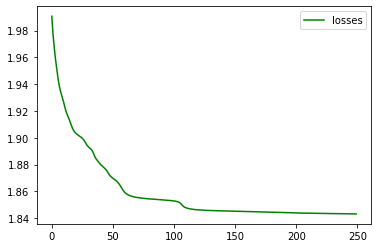

In [31]:
plt.plot(losses, label='losses', color='g')
plt.legend()
plt.show()

I applied the model on CPU just considering your convenience that you may run it on your laptop.
The accuracy of prediction is low in part because the training epoches are not enough, I set it as small just to make a quick presentation.

Another form(CUDA/CPU), in this form, we can use the pytorch built-in optimizer which is much more efficient than we used above!

We still use the A and features defined above, now we train.

In [32]:
import torch

class GCNlayer(torch.nn.Module):
    def __init__(self, feat_dim, out_dim, bias=False):
        super(GCNlayer, self).__init__()
        # we set two learnable parameters self.W and self.bias (torch.nn.Parameter)
        self.W = torch.nn.Parameter(data=torch.rand(feat_dim, out_dim), requires_grad=True) 
        if bias:
            self.bias = torch.nn.Parameter(
                data=torch.empty(1,out_dim).uniform_(0,0.05), requires_grad=True)
        else:
            self.bias = None
        
    def forward(self,A,X): 
        D = torch.diag(pow(torch.sum(A, axis=0),-1/2))
        if self.bias != None:
            output = torch.mm(torch.mm(torch.mm(torch.mm(D, A),D),X),self.W) + self.bias
        else:
            output = torch.mm(torch.mm(torch.mm(torch.mm(D, A),D),X),self.W)
        return(output)
    
    
class GCN(torch.nn.Module):
    def __init__(self, feat_dim, hidden_dim, num_class, droprate=0.1, bias=True):
        super(GCN, self).__init__()
        self.GConv1 = GCNlayer(feat_dim, hidden_dim, bias)
        self.GConv2 = GCNlayer(hidden_dim, num_class, bias)
        self.dropout = torch.nn.Dropout(p=droprate, inplace=False)
        self.relu = torch.nn.ReLU()

    def forward(self, A, X): #input -> hidden -> dropout -> logsoftmax, forward propagation
        #D = torch.diag(pow(torch.sum(A, axis=0),-1/2))
        hidden = self.relu(self.GConv1(A, X)) 
        hidden = self.dropout(hidden)
        output = self.GConv2(A, hidden)
        output = torch.nn.LogSoftmax(dim=1)(output)
        return output


In [33]:
# automatic detect your gpu, if you do not have gpu, no worry, it will train on cpu
# normally, in industry, we need to split train, validation, test dataset; but usually, splitting into train and test set is enough
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model = GCN(feat_dim, 16, num_class, droprate=0.5, bias=False)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
losses = []

for epoch in range(200):
    optimizer.zero_grad()#pytorch will accumulate the gradient, we need to clean it after each epoch training
    output = model(A.to(device), features.to(device))

    loss = torch.nn.NLLLoss()(output[train_mask].to(device), label_list[train_mask].long().to(device)) # loss defined on train set
    loss.backward(retain_graph=True) # back propagation
    optimizer.step() # updated parameter
    loss_val = torch.nn.NLLLoss()(output[test_mask].to(device), label_list[test_mask].long().to(device)) # loss defined on test set

    print('epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.3f}'.format(loss.item()),
          'loss_val: {:.3f}'.format(loss_val.item()))

    losses.append(loss.data.cpu().numpy())

epoch: 001 loss_train: 12.333 loss_val: 9.069
epoch: 002 loss_train: 10.961 loss_val: 7.978
epoch: 003 loss_train: 10.136 loss_val: 7.148
epoch: 004 loss_train: 7.998 loss_val: 7.001
epoch: 005 loss_train: 7.684 loss_val: 6.443
epoch: 006 loss_train: 6.653 loss_val: 6.587
epoch: 007 loss_train: 6.922 loss_val: 6.339
epoch: 008 loss_train: 6.287 loss_val: 6.962
epoch: 009 loss_train: 5.920 loss_val: 6.581
epoch: 010 loss_train: 5.623 loss_val: 6.397
epoch: 011 loss_train: 5.935 loss_val: 6.344
epoch: 012 loss_train: 5.387 loss_val: 6.329
epoch: 013 loss_train: 4.804 loss_val: 5.742
epoch: 014 loss_train: 5.297 loss_val: 5.922
epoch: 015 loss_train: 4.870 loss_val: 5.652
epoch: 016 loss_train: 4.935 loss_val: 6.049
epoch: 017 loss_train: 5.085 loss_val: 5.490
epoch: 018 loss_train: 4.057 loss_val: 5.349
epoch: 019 loss_train: 4.528 loss_val: 5.084
epoch: 020 loss_train: 4.026 loss_val: 5.053
epoch: 021 loss_train: 3.597 loss_val: 4.616
epoch: 022 loss_train: 3.266 loss_val: 4.431
epoch: 

epoch: 183 loss_train: 0.172 loss_val: 1.143
epoch: 184 loss_train: 0.096 loss_val: 1.093
epoch: 185 loss_train: 0.122 loss_val: 1.145
epoch: 186 loss_train: 0.099 loss_val: 1.167
epoch: 187 loss_train: 0.151 loss_val: 1.071
epoch: 188 loss_train: 0.093 loss_val: 1.201
epoch: 189 loss_train: 0.167 loss_val: 1.112
epoch: 190 loss_train: 0.127 loss_val: 1.086
epoch: 191 loss_train: 0.073 loss_val: 1.083
epoch: 192 loss_train: 0.110 loss_val: 1.105
epoch: 193 loss_train: 0.067 loss_val: 1.062
epoch: 194 loss_train: 0.111 loss_val: 1.005
epoch: 195 loss_train: 0.104 loss_val: 1.129
epoch: 196 loss_train: 0.113 loss_val: 1.054
epoch: 197 loss_train: 0.111 loss_val: 1.070
epoch: 198 loss_train: 0.102 loss_val: 1.055
epoch: 199 loss_train: 0.073 loss_val: 1.077
epoch: 200 loss_train: 0.146 loss_val: 1.097


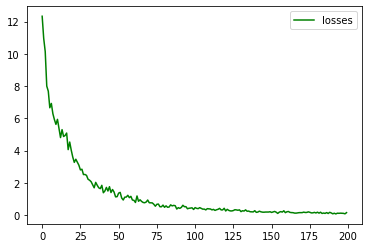

In [34]:
plt.plot(losses, label='losses', color='g')
plt.legend()
plt.show()

In [35]:
model.eval()
_, prediction = model(A.to(device),features.cuda()).max(dim=1)
acc = acc_calc(label_list[test_mask].to(device),prediction[test_mask].to(device))
print("accuracy of in test set: ", acc)

accuracy of in test set:  0.794


I believe still have a gap between our model and the model assigned in paper--code can be see in(https://github.com/tkipf/gcn)